stock_url https://tw.stock.yahoo.com/quote/1101
{'1101': '33.00'}
stock_url https://tw.stock.yahoo.com/quote/2409
{'1101': '33.00', '2409': '17.65'}
stock_url https://tw.stock.yahoo.com/quote/2301
{'1101': '33.00', '2409': '17.65', '2301': '104.5'}
stock_url https://tw.stock.yahoo.com/quote/3019
{'1101': '33.00', '2409': '17.65', '2301': '104.5', '3019': '68.0'}
stock_url https://tw.stock.yahoo.com/quote/2382
{'1101': '33.00', '2409': '17.65', '2301': '104.5', '3019': '68.0', '2382': '274.5'}
stock_url https://tw.stock.yahoo.com/quote/2356
{'1101': '33.00', '2409': '17.65', '2301': '104.5', '3019': '68.0', '2382': '274.5', '2356': '53.7'}
stock_url https://tw.stock.yahoo.com/quote/2317
{'1101': '33.00', '2409': '17.65', '2301': '104.5', '3019': '68.0', '2382': '274.5', '2356': '53.7', '2317': '187.5'}
更新時間:15:24

 時間:15:24:29 
 台泥 [1101] 
 盤中最低價:33.0 
 盤中最高價:33.55
 最新成交價: 33.00 
 成交量: 2625.0 
 開盤價: 33.2
 昨收價:32.85 
 本益比:0.46%


C:\Users\wratt\AppData\Local\Temp\ipykernel_19112\621615295.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['漲跌百分比'].iloc[x] = (df['當盤成交價'].iloc[x] - df['昨收價'].iloc[x])/df['昨收價'].iloc[x]
C:\Users\wratt\AppData\Local\Temp\ipykernel_19112\621615295.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['漲跌百分比'].iloc[x] = (df['當盤成交價'].iloc[x] - df['昨收價'].iloc[x])/df['昨收價'].iloc[x]
C:\Users\wratt\AppData\Local\Temp\ipykernel_19112\621615295.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

{"status":200,"message":"ok"}

 時間:15:24:29 
 友達 [2409] 
 盤中最低價:17.65 
 盤中最高價:18.1
 最新成交價: 17.65 
 成交量: 4172.0 
 開盤價: 18.0
 昨收價:17.95 
 本益比:-1.67%
{"status":200,"message":"ok"}

 時間:15:24:29 
 光寶科 [2301] 
 盤中最低價:103.5 
 盤中最高價:106.5
 最新成交價: 104.5 
 成交量: 914.0 
 開盤價: 103.5
 昨收價:104.0 
 本益比:0.48%
{"status":200,"message":"ok"}

 時間:15:24:29 
 亞光 [3019] 
 盤中最低價:67.5 
 盤中最高價:68.8
 最新成交價: 68.0 
 成交量: 39.0 
 開盤價: 67.9
 昨收價:67.2 
 本益比:1.19%
{"status":200,"message":"ok"}

 時間:15:24:29 
 廣達 [2382] 
 盤中最低價:273.0 
 盤中最高價:277.0
 最新成交價: 274.5 
 成交量: 1759.0 
 開盤價: 277.0
 昨收價:274.5 
 本益比:0.00%
{"status":200,"message":"ok"}

 時間:15:24:29 
 英業達 [2356] 
 盤中最低價:53.0 
 盤中最高價:54.5
 最新成交價: 53.7 
 成交量: 2746.0 
 開盤價: 53.8
 昨收價:52.9 
 本益比:1.51%
{"status":200,"message":"ok"}

 時間:15:24:30 
 鴻海 [2317] 
 盤中最低價:182.5 
 盤中最高價:188.0
 最新成交價: 187.5 
 成交量: 6364.0 
 開盤價: 184.0
 昨收價:180.5 
 本益比:3.88%
{"status":200,"message":"ok"}


,股票代號,公司簡稱,當盤成交價,當盤成交量,累積成交量,開盤價,最高價,最低價,昨收價,漲跌百分比
0,1101,台泥,33.000000,2625.000000,17478.000000,33.200000,33.550000,33.000000,32.850000,0.004566
1,2409,友達,17.650000,4172.000000,36543.000000,18.000000,18.100000,17.650000,17.950000,-0.016713
2,2301,光寶科,104.500000,914.000000,10827.000000,103.500000,106.500000,103.500000,104.000000,0.004808
3,3019,亞光,68.000000,39.000000,1100.000000,67.900000,68.800000,67.500000,67.200000,0.011905
4,2382,廣達,274.500000,1759.000000,16610.000000,277.000000,277.000000,273.000000,274.500000,0.000000
5,2356,英業達,53.700000,2746.000000,41294.000000,53.800000,54.500000,53.000000,52.900000,0.015123
6,2317,鴻海,187.500000,6364.000000,124183.000000,184.000000,188.000000,182.500000,180.500000,0.038781


台泥
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 27877 (\N{CJK UNIFIED IDEOGRAPH-6CE5}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
友達
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 21451 (\N{CJK UNIFIED IDEOGRAPH-53CB}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
光寶科
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 23542 (\N{CJK UNIFIED IDEOGRAPH-5BF6}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
亞光
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
廣達
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 24291 (\N{CJK UNIFIED IDEOGRAPH-5EE3}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
英業達
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 26989 (\N{CJK UNIFIED IDEOGRAPH-696D}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success
鴻海
{"status":200,"message":"ok"}


c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 40251 (\N{CJK UNIFIED IDEOGRAPH-9D3B}) missing from current font.
  fig.savefig(**save)
c:\work\anaconda\envs\test\lib\site-packages\mplfinance\plotting.py:942: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.savefig(**save)


{"status":200,"message":"ok"}
success


c:\work\anaconda\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40251 (\N{CJK UNIFIED IDEOGRAPH-9D3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\work\anaconda\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


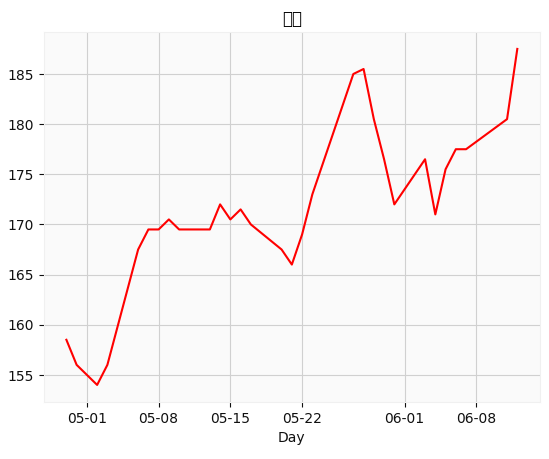

In [14]:
import urllib
import dateutil 
import matplotlib.pyplot as plt
import pandas
import datetime,time
import json
import twstock
import requests
import schedule
from pathlib import Path
import matplotlib.dates as mpl_dates
import time
import mplfinance as mpf
from IPython.display import display, clear_output
from urllib.request import urlopen
import sched
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

s = sched.scheduler(time.time, time.sleep)

def getFormateFloat(NumberString):
    if NumberString != "-":
        NumberString = format(float(NumberString), '.2f')
        return NumberString

def SendLineNotify(msgString):
    #lineToken = 'HcmWNJxxh6s07aL65t05LCzNudclQasRz8VoacOBRuf'  ##個人測試用
    lineToken = 'H4lHQ7oA2PHhBQraqTxiVtT16FsmpsgvCs7varGlWz4'
    url = "https://notify-api.line.me/api/notify"
    payload={'message':{msgString}}
    headers = {'Authorization': 'Bearer ' + lineToken}
    response = requests.request("POST", url, headers=headers, data=payload)
    print(response.text)

def GetStockInfo():
    #匯入
    companyList = ['1101', '2409', '2301','3019']

    # 取得多檔即時資料
    stocks = twstock.realtime.get(companyList)
    df_realtime = pandas.DataFrame(stocks)

    for item in companyList:
        currentPrice = getFormateFloat(stocks[item]["realtime"]["latest_trade_price"])
        openPrice = getFormateFloat(stocks[item]["realtime"]["open"])
        lowPrice = getFormateFloat(stocks[item]["realtime"]["low"])
        highPrice = getFormateFloat(stocks[item]["realtime"]["high"])
        #estimatePrice = openPrice * 0.03
        tradeVolume = stocks[item]["realtime"]["trade_volume"]
        print(stocks[item]["info"]["name"])
        print(currentPrice)

        t = time.localtime()
        localtime = time.strftime("%H:%M:%S", t)
        
        msg=(f'\n 時間:{localtime} \n {stocks[item]["info"]["name"]} [{stocks[item]["info"]["code"]}] \n 盤中最低價:{lowPrice} \n 盤中最高價:{highPrice}  \n 最新成交價: {currentPrice} \n 成交量: {tradeVolume} \n 開盤價: {openPrice}')
        #當有最新成交價才寄出
        if (currentPrice != "None"):    
            SendLineNotify(msg) 
            print(msg)

        #當目前成交價大於開盤價3%則通知 
        # if currentPrice == "-":
        #     continue
        # if currentPrice >= estimatePrice:
        #     msg = (f' \n {stocks[item]["info"]["name"]} {stocks[item]["info"]["code"]} \n low:{lowPrice} ||high:{highPrice}  \n last_price {currentPrice}||成交量 {tradeVolume} \n 開盤價 {openPrice}||預估價格 {estimatePrice} \n 目前成交價高於開盤價格3%!')
        #     SendLineNotify(msg)

#每日股價查詢
def getStockInfo(stock_num):
    try:
        # 取得證交所股票data
        stock = twstock.Stock(stock_num)
        return stock
    except:
        print("Error")
    finally:
        time.sleep(15)

#每日股價查詢
def getStockInfoByK(stock):
    try:
        # 取得證交所股票data
        df = pandas.DataFrame({
            'date': stock.date,
            'open': stock.open,
            'high': stock.high,
            'low': stock.low,
            'close': stock.price,
            'volume': stock.capacity,  # 使用 twstock.Stock.capacity 來取得成交量
        }, index=pandas.to_datetime(stock.date, format='%Y%m%d'))
        return df
    except:
        print("Error")
    finally:
        time.sleep(15)

#產生每股一個月內股價資訊
def SetStockPhoto(stock_CN_Name,stock):
    print(stock_CN_Name)
    stock_price = stock.price
    stock_name = stock.sid
    date = stock.date # 時間
    open = stock.open # 開
    high = stock.high # 高
    ow = stock.low # 低
    close = stock.price # 收
    month = range(1,13)
    date_format= mpl_dates.DateFormatter("%M %d")
    imagePath = '../../../test.jpg'
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    plt.clf()
    plt.plot(date,stock_price,'red')
    plt.xlabel('Day')
    plt.title (stock_CN_Name)
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter('%m-%d'))
    plt.savefig(imagePath)
    SendPhotoLineNotify(stock_name+'-'+ stock_CN_Name+' 一個月內股價資訊圖',imagePath)

#產生每股數天K線圖
def SetStockPhotoByK(stock_CN_Name,stock):
    df = getStockInfoByK(stock)
    mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    # 針對線圖的外觀微調，將上漲設定為紅色，下跌設定為綠色，符合台股表示習慣
    # 接著把自訂的marketcolors放到自訂的style中，而這個改動是基於預設的yahoo外觀
    image_path = '../../../testK.jpg'
    save_path = dict(fname=image_path)
    kwargs = dict(type='candle', mav=(5, 20, 60), volume=True,savefig= save_path,
              figratio=(10, 8), figscale=0.75, title=stock_CN_Name, style=s)
    # 設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值
    mpf.plot(df, **kwargs)
    SendPhotoLineNotify(stock.sid+'-'+ stock_CN_Name+'股價K線圖',image_path)
  

#寄送每日股價圖
def SendPhotoLineNotify(msgString,imagePath):
    #lineToken = 'HcmWNJxxh6s07aL65t05LCzNudclQasRz8VoacOBRuf'  ##個人測試用
    lineToken = 'H4lHQ7oA2PHhBQraqTxiVtT16FsmpsgvCs7varGlWz4'
    url = "https://notify-api.line.me/api/notify"
    payload={'message':{msgString}}
    image = Path(imagePath).read_bytes()
    imageFile = {'imageFile' : image}
   
    headers = {'Authorization': 'Bearer ' + lineToken}
    response = requests.request("POST", url, headers=headers, data=payload, files=imageFile)
    print(response.text)
   

def SendStockPhoto(companyList):
    #匯入
    #companyList = ['1101', '2409', '2301','3019']
    companyDict = {"1101":"台泥","2409":"友達","2301":"光寶科","3019":"亞光","2382":"廣達","2356":"英業達","2317":"鴻海"}
    for item in companyList:
        companyString = companyDict[item]
        #取得股票資訊
        stock =getStockInfo(item)
        #產生每股一個月內股價資訊圖
        SetStockPhoto(companyString,stock)

        #產生每股數天K線圖
        SetStockPhotoByK(companyString,stock)

        # 刪除檔案路徑
        file = Path("../../../test.jpg")
        file.unlink()
        file = Path("../../../testK.jpg")
        file.unlink()
        print('success')


def tableColor(val):
    if val > 0:
        color = 'red'
    elif val < 0:
        color = 'green'
    else:
        color = 'white'
    return 'color: %s' % color


def stock_crawler(targets):
    
    clear_output(wait=True)
    stock_dict = getStockNewFunction(companyList)
    
    
    # 組成stock_list
    stock_list = '|'.join('tse_{}.tw'.format(target) for target in targets) 
    
    #　query data
    query_url = "http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch="+ stock_list
    data = json.loads(urlopen(query_url).read())

    # 過濾出有用到的欄位
    columns = ['c','n','z','tv','v','o','h','l','y']
    df = pandas.DataFrame(data['msgArray'], columns=columns)
    df.columns = ['股票代號','公司簡稱','當盤成交價','當盤成交量','累積成交量','開盤價','最高價','最低價','昨收價']
    df.insert(9, "漲跌百分比", 0.0) 
    
    # 新增漲跌百分比
    for x in range(len(df.index)):
        if df['當盤成交價'].iloc[x] != '-':
            df.iloc[x, [2,3,4,5,6,7,8]] = df.iloc[x, [2,3,4,5,6,7,8]].astype(float)
            df['漲跌百分比'].iloc[x] = (df['當盤成交價'].iloc[x] - df['昨收價'].iloc[x])/df['昨收價'].iloc[x] 
    
    # 紀錄更新時間
    time = datetime.datetime.now()  
    print("更新時間:" + str(time.hour)+":"+str(time.minute))
    
    ##整理DF成MSG並送出LINE
    SetMSGToLINENOTIFY(df,stock_dict)

    
    # show table
    df = df.style.applymap(tableColor, subset=['漲跌百分比'])
    display(df)

    
    
    start_time = datetime.datetime.strptime(str(time.date())+'9:30', '%Y-%m-%d%H:%M')
    end_time =  datetime.datetime.strptime(str(time.date())+'13:30', '%Y-%m-%d%H:%M')
    
    # 判斷爬蟲終止條件
    if time >= start_time and time <= end_time:
        s.enter(1, 0, stock_crawler, argument=(targets,))


###將股票資訊傳入LINE
def SetMSGToLINENOTIFY(df:pandas.DataFrame,stock_dict):
    df_rows_count = int(df.shape[0])
    
    for number in range(0,df_rows_count):
        #
        new_price = stock_dict[df.iat[number,0]]
        t = time.localtime()
        localtime = time.strftime("%H:%M:%S", t)
        
        msg=(f'\n 時間:{localtime} \n {df.iat[number,1]} [{df.iat[number,0]}] \n 盤中最低價:{df.iat[number,7]} \n 盤中最高價:{df.iat[number,6]}\n 最新成交價: {new_price} \n 成交量: {df.iat[number,3]} \n 開盤價: {df.iat[number,5]}')
        msg = msg + (f'\n 昨收價:{df.iat[number,8]} \n 本益比:{(float(df.iat[number,9])):.2%}')
        print(msg)
        SendLineNotify(msg)

    


#stock_crawler(companyList)
#GetStockInfo()



# 將剛剛的抓取程式變成「函式」
def getStockInYahoo(url,stock_dict):
    web = requests.get(url)
    soup = BeautifulSoup(web.text, "html.parser")
   
    try:
         title = soup.find_all('h1')[1].text
         stock_price = soup.find_all(class_ ='Fz(32px) Fw(b) Lh(1) Mend(16px) D(f) Ai(c) C($c-trend-up)')[0] # 如果出現錯誤，可以使用 .Fz\(32px\) 轉義
         stock_num = soup.find_all(class_ ='C($c-icon) Fz(24px) Mend(20px)')[0]
         stock_dict[stock_num.text] = stock_price.text
    except:
        try:
            stock_price = soup.find_all(class_ ='Fz(32px) Fw(b) Lh(1) Mend(16px) D(f) Ai(c) C($c-trend-down)')[0] # 如果出現錯誤，可以使用 .Fz\(32px\) 轉義
            stock_num = soup.find_all(class_ ='C($c-icon) Fz(24px) Mend(20px)')[0]
            stock_dict[stock_num.text] = stock_price.text
        except:
            stock_price = soup.find_all(class_ ='Fz(32px) Fw(b) Lh(1) Mend(16px) D(f) Ai(c)')[0] # 如果出現錯誤，可以使用 .Fz\(32px\) 轉義
            stock_num = soup.find_all(class_ ='C($c-icon) Fz(24px) Mend(20px)')[0]
            stock_dict[stock_num.text] = stock_price.text

    return stock_dict

def getStockNewFunction(stock_list):
    stock_dict = {}
    for stock in stock_list:
        stock_url = 'https://tw.stock.yahoo.com/quote/' + stock
        print('stock_url',stock_url)
        stock_dict = getStockInYahoo(stock_url,stock_dict)
        print(stock_dict)
    
    return stock_dict



companyList = ['1101', '2409', '2301','3019','2382','2356','2317']
stock_dict = {}
executor = ThreadPoolExecutor()         # 建立非同步的多執行緒的啟動器
with ThreadPoolExecutor() as executor:
    executor.map(stock_crawler(companyList))
    executor.map(SendStockPhoto(companyList))



# if __name__ == "__main__":
#     schedule.every().day.at("14:25").do(SendStockPhoto)     
#     schedule.every(10).minutes.until("14:30").do(GetStockInfo)
#     while True:
#         schedule.run_pending()
#         time.sleep(1)
